# ICELL88 Demo
This notebook runs the first demo with Wafergen ICELL88 demo run. We have three cells, Embryoning ESC and Differentiated d1 which again have two replicates d1.1 and d1.2. ICELL8 have couple of their own controls, 3T3, Pos_Ctrl, and Neg_Ctrl. However, Neg_Ctrl would be dropped at the beginning of the analysis as we do not expect anything to happen there.

This demo maps with the transcripts of `mm10`. However, we would be interested to run it through the genome mapping to have an idea of how does it behave when we map it to genes.

In [1]:
import subprocess, os, csv, signal, pysam, rpy2
import numpy as np
import matplotlib.pyplot as plt
import readline
import rpy2.robjects
from matplotlib.pyplot import *
%matplotlib inline
 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [2]:
%load_ext rpy2.ipython

In [4]:
%%R
library(Rtsne)
library(DESeq2)
library(ggplot2)
library(lattice)
library(GGally)
library(genefilter)
library(plyr)
library(M3Drop)
library(scde)
library(monocle)
library(reshape)

We first read the result files as input. There are two result files, the `sce-1059_mm_refseq_merged.report.csv` holds a summary report and the actual raw result file is `sce-1059_mm_refseq.genematrix_sansUMI.csv`. In this analysis reads were aligned with the transcripts. So basically, we will look at the transcripts.

For ease of analysis here I will mostly keep what Karthik is doing.

While reading the `sce-1059_mm_refseq_merged.report.csv` we will skip the first 8 lines as they were mostly describing the sample name, total reads, bad reads and so on...

In [5]:
%%R
report <- read.csv(file="sce-1059_mm_refseq_merged.report.csv",skip=8)
genematrix <- read.table(file="sce-1059_mm_refseq.genematrix_sansUMI.csv", sep=",")

In [6]:
%%R
colnames(report)

 [1] "Barcode"                      "Type"                        
 [3] "Source.Sample.Name"           "Dispense.Order"              
 [5] "X384.Well.Plate.Location"     "Chip.Row.ID"                 
 [7] "Chip.Column.ID"               "Image.ID"                    
 [9] "Barcode.Read.Pairs"           "Distinct.UMIs"               
[11] "ERCC.Read.Pairs"              "Trimmed.Read.Pairs"          
[13] "NoContam.Read.Pairs"          "Mitochondria.Alignments"     
[15] "Mitochondria.Read.Pairs"      "Total.Barcode.Alignments"    
[17] "Distinct.Genes.w..Alignments" "Distinct.Gene.UMI.Combos"    
[19] "Aligned"                      "Assigned"                    
[21] "Ambiguity"                    "Chimera"                     
[23] "Duplicate"                    "FragementLength"             
[25] "MappingQuality"               "MultiMapping"                
[27] "NoFeatures"                   "Nonjunction"                 
[29] "Secondary"                    "Unmapped"                

Above are all the report column files

In [7]:
%%R
print(paste0('genematrix dimension: ', dim(genematrix)))

[1] "genematrix dimension: 405"   "genematrix dimension: 87501"


So `genematrix` holds in total `405` cells and `87501` transcripts. Each of the row represents on cells which are encoded with the barcode of the cell. Then the column represents each of the transcript. 

In most of my analysis it is actually the other way round, where the column represents cell and row represents genes. So to make it compatible to my analysis I will transpose it. However, for the time being I would keep as it is, to run with Karthik analysis.

In [8]:
%%R
print(genematrix[1:5,1:4])

            NM_001001130.2 NM_001001144.3 NM_001001160.3 NM_001001176.2
AACCAACCAAG              0              0              1              0
AACCAACTCCG              0              0              0              0
AACCATAAGTA              0              0              0              0
AACCATCATAA              0              0              2              0
AACCATTGGCT              0              0              0              0


This is the raw read of the transcripts.

There is a `UNION` row at the end of report file. I am not sure at this stage what is it for!!! But as Karthik did, I will also get rid of it anyway.

In [9]:
%%R
#Check for and separate UNION row
if(as.character(report[dim(report)[1],1]) == 'UNION'){
  union <- report[dim(report)[1],]
  union <- droplevels(union)
  report <- report[1:((dim(report)[1]) -1),]
  report <- droplevels(report)
}

We now remove low barcodes (if any), incl. Neg Ctrls. However, here Karthik is only removing the "Neg_Ctrl". We can modify it to remove the low barcodes by looking at `Total.Barcode.Alignments` column of the report or any other column we find suitable.

In [10]:
%%R
report_sub <- report[!(report$Type %in% c("Neg_Ctrl")),]
report_sub <- droplevels(report_sub)

We now remove barcodes from `genematrix` that are not in `report_sub`

In [11]:
%%R
genematrix_orig <- genematrix
genematrix <- genematrix_orig[as.character(report_sub$Barcode),,drop=F]

We now check whether the barcodes ordering in the two files are sme

In [12]:
%%R
all(rownames(genematrix) == report_sub$Barcode)

[1] TRUE


We now do a `counts per million` normalization

In [13]:
%%R
norm_factor_cpm <- rowSums(genematrix) / 1000000
genematrix_cpm <- genematrix / norm_factor_cpm

We then add a psuedocount and do a log transform of the data

In [ ]:
%%R
genematrix_cpm_log2plus1 <- log2(genematrix_cpm+1)

In [ ]:
%%R
FinalPCAData <- genematrix_cpm_log2plus1
pcaPRComp <- prcomp(FinalPCAData)

We now do PCA on log-transformed data.

In [ ]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)
PCx=1
PCy=2

percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA First Two Components")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

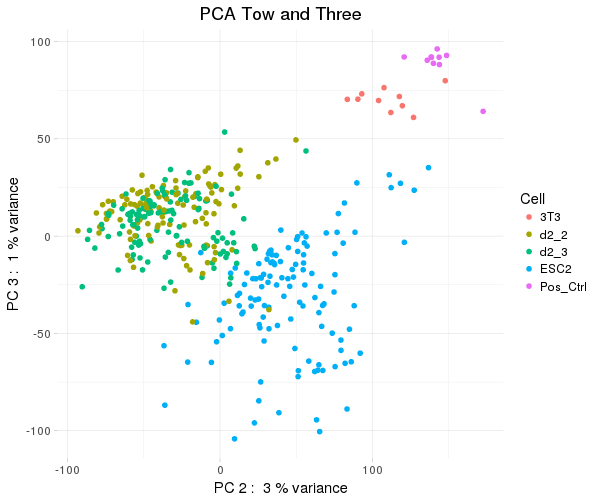

In [126]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)
PCx=2
PCy=3

percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA Tow and Three")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

In [23]:
%%R
#Write pca loading to csv file
write.csv(round(pcaPRComp$x[,1:10],3),file=paste0("icell8_manchester_demo","_pca_loadings_dump.csv",sep=''))

In [ ]:
%%R
nmax = 10
if(dim(pcaPRComp$x)[1] < 10){ nmax = dim(pcaPRComp$x)[1] }
txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
pca_var = pcaPRComp$sdev ^ 2
pca_var_percent <- 100 * pca_var / sum(pca_var)
pca_var_percent_first10 <- NA * pca_var
pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

pca_corr_reads <- apply(pcaPRComp$x,2,function(x) cor(x,report_sub$Assigned))
    
pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1),round(pca_corr_reads,3))
rownames(pca_var_out) <- colnames(pcaPRComp$x)
colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1,"PC_Corr_AssignedReads")

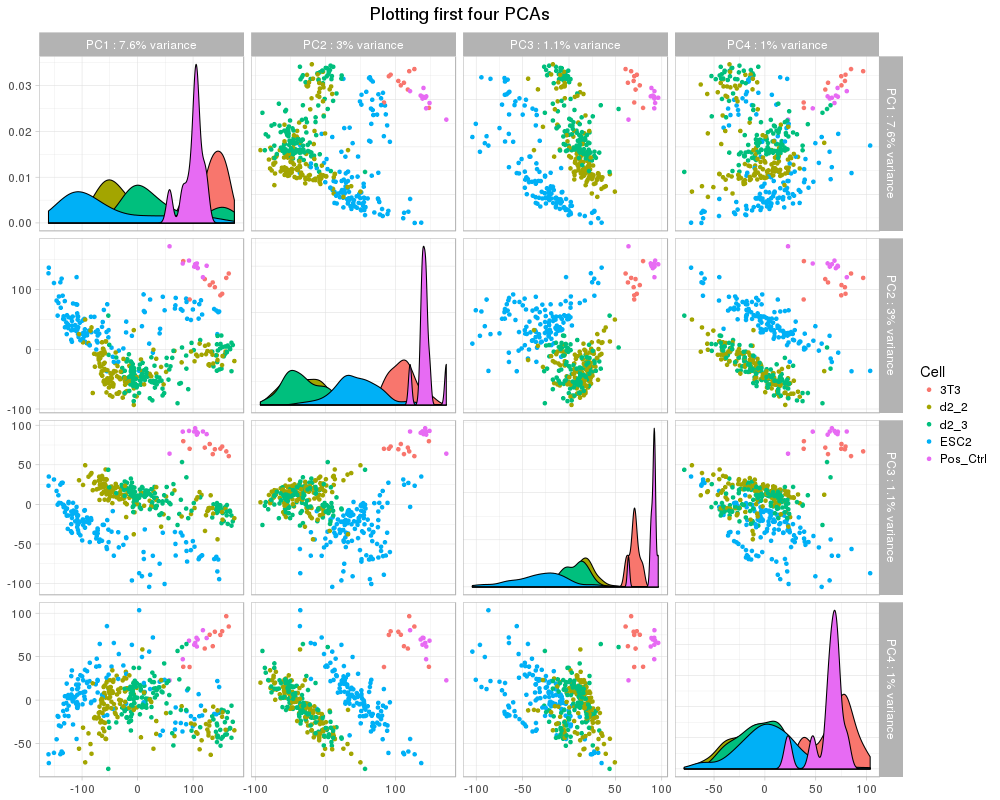

In [158]:
%%R -w 1000 -h 800
# Set the number of columns you like to display
nColToDisplay = 4
df <- as.data.frame(pcaPRComp$x)
df$Cell=Status
p <- ggpairs(df, columns=1:nColToDisplay, upper=list(continuous="points"), 
             title='Plotting first four PCAs', 
             mapping = aes_string(color="Cell"),
             legend = c(1,nColToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nColToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nColToDisplay], '% variance')))+
    theme_light(base_size=15)+     
    theme(plot.title = element_text(hjust = 0.5))
    
print(p)

Doing a PCA variance plot to see how much variance are covered by these PCAs

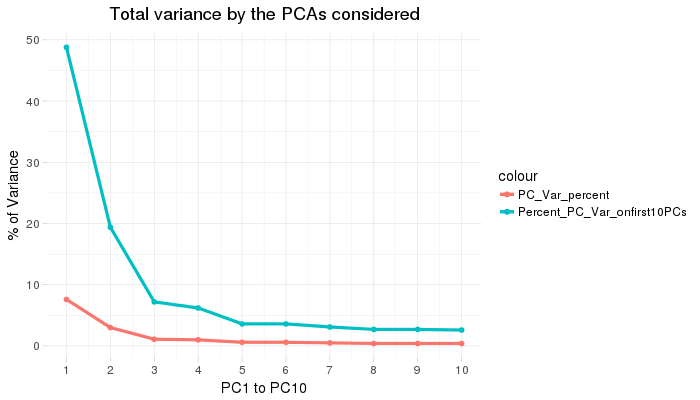

In [181]:
%%R -w 700 -h 400
p <- ggplot(pca_var_out[1:10,])
p <- p + geom_line(aes(x=c(1:10), y = PC_Var_percent, color="PC_Var_percent"), size=1.5)+
         geom_point(aes(x=c(1:10), y = PC_Var_percent, color="PC_Var_percent"), size = 2)+
         geom_line(aes(x=c(1:10), y = Percent_PC_Var_onfirst10PCs, color="Percent_PC_Var_onfirst10PCs"), size=1.5)+
         geom_point(aes(x=c(1:10), y = Percent_PC_Var_onfirst10PCs, color="Percent_PC_Var_onfirst10PCs"), size = 2)+
         ggtitle("Total variance by the PCAs considered")+
         xlab(paste("PC1 to PC10"))+
         ylab(paste("% of Variance"))+     
         theme_light(base_size=15)+     
         theme(plot.title = element_text(hjust = 0.5),
              panel.border     = element_blank())+
         scale_x_continuous(breaks=c(1:10))
print(p)
  #geom_line(aes(y = Percent_PC_Var_onfirst10PCs, colour = "Percent_PC_Var_onfirst10PCs"))

Now we plot the t-SNE. For this we are using the first six loading of PCA. One of the reason of choosing the PCA loading is that t-SNE is a stochastic method. So if we took the actual value then it might not show the same figures all the time. But if we take the PCA loadings then it actually captures the variability within the data and will be more stable

In [178]:
%%R
rtsne_pca_out <- Rtsne(as.matrix(pcaPRComp$x[,1:6]))

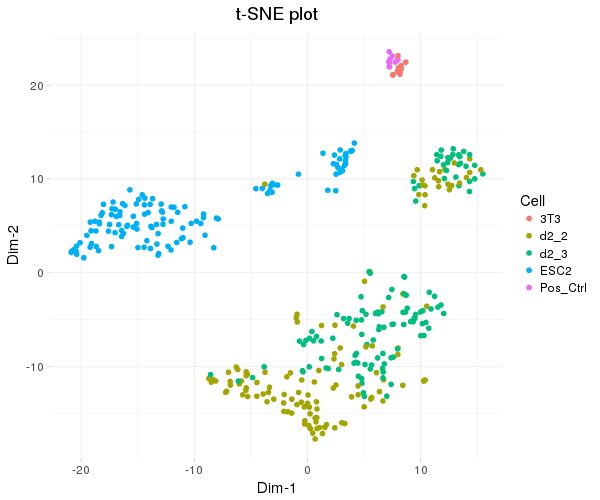

In [179]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)

df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2],Cell=Status)
p1<-ggplot(df, aes_string(x="X",y ="Y",color="Cell"))
p1<-p1 + ggtitle("t-SNE plot")
p1<-p1 + geom_point(size = 2)
p1<-p1 + xlab(paste("Dim-1"))
p1<-p1 + ylab("Dim-2")+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

### We now would be plotting the same thing but only taking the 500 most variable transcripts

In [185]:
%%R
genematrix_cpm_log2plus1_T <- t(genematrix_cpm_log2plus1)
genematrix_cpm_log2plus1_T <- genematrix_cpm_log2plus1_T[order(rowVars(genematrix_cpm_log2plus1_T), decreasing = TRUE)[1:500],]
MostVariable500 <- t(genematrix_cpm_log2plus1_T)

In [186]:
%%R
FinalPCAData <- MostVariable500
pcaPRComp <- prcomp(FinalPCAData)

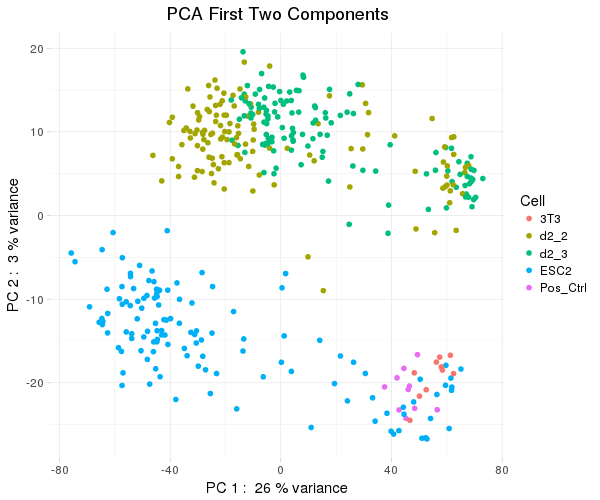

In [187]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)
PCx=1
PCy=2

percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA First Two Components")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

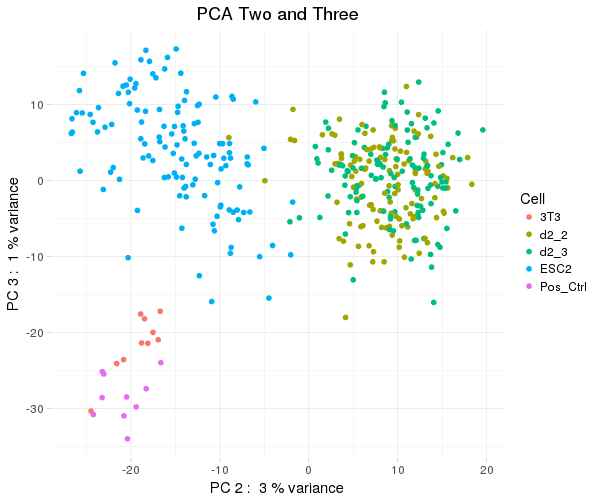

In [189]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)
PCx=2
PCy=3

percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA Two and Three")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

In [191]:
%%R
nmax = 10
if(dim(pcaPRComp$x)[1] < 10){ nmax = dim(pcaPRComp$x)[1] }
txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
pca_var = pcaPRComp$sdev ^ 2
pca_var_percent <- 100 * pca_var / sum(pca_var)
pca_var_percent_first10 <- NA * pca_var
pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

pca_corr_reads <- apply(pcaPRComp$x,2,function(x) cor(x,report_sub$Assigned))
    
pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1),round(pca_corr_reads,3))
rownames(pca_var_out) <- colnames(pcaPRComp$x)
colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1,"PC_Corr_AssignedReads")

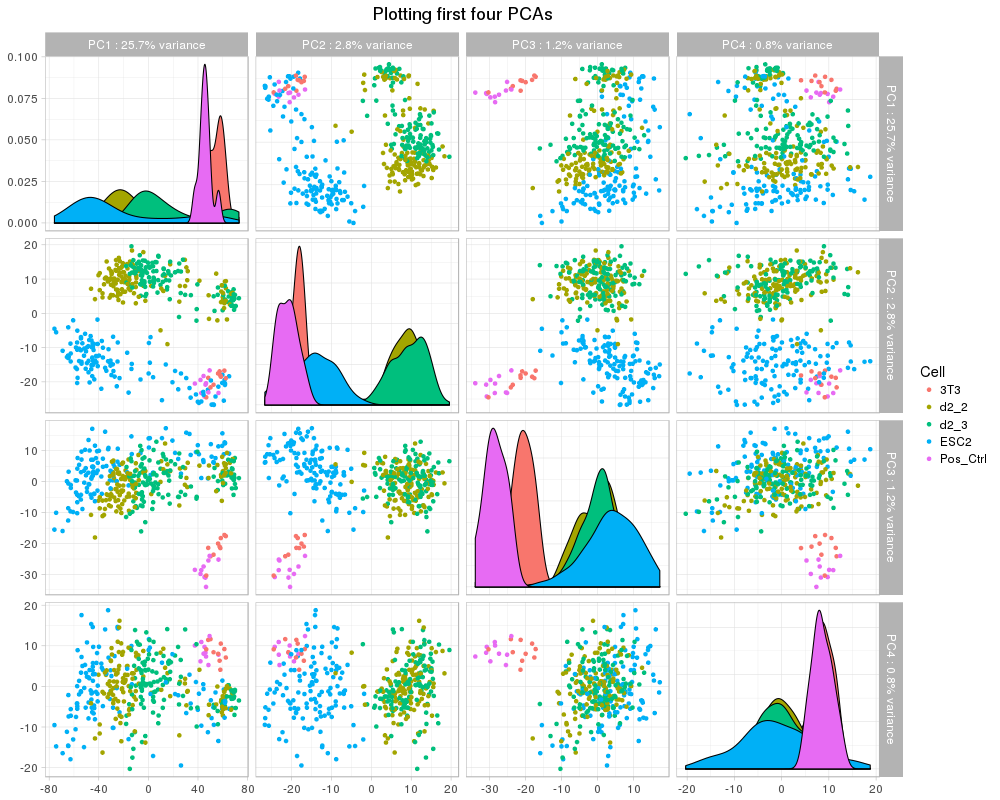

In [194]:
%%R -w 1000 -h 800
# Set the number of columns you like to display
nColToDisplay = 4
df <- as.data.frame(pcaPRComp$x)
df$Cell=Status
p <- ggpairs(df, columns=1:nColToDisplay, upper=list(continuous="points"), 
             title='Plotting first four PCAs', 
             mapping = aes_string(color="Cell"),
             legend = c(1,nColToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nColToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nColToDisplay], '% variance')))+
    theme_light(base_size=15)+     
    theme(plot.title = element_text(hjust = 0.5))
    
print(p)

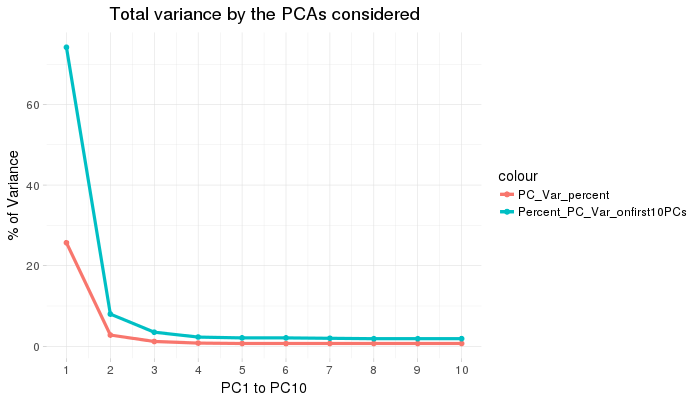

In [195]:
%%R -w 700 -h 400
p <- ggplot(pca_var_out[1:10,])
p <- p + geom_line(aes(x=c(1:10), y = PC_Var_percent, color="PC_Var_percent"), size=1.5)+
         geom_point(aes(x=c(1:10), y = PC_Var_percent, color="PC_Var_percent"), size = 2)+
         geom_line(aes(x=c(1:10), y = Percent_PC_Var_onfirst10PCs, color="Percent_PC_Var_onfirst10PCs"), size=1.5)+
         geom_point(aes(x=c(1:10), y = Percent_PC_Var_onfirst10PCs, color="Percent_PC_Var_onfirst10PCs"), size = 2)+
         ggtitle("Total variance by the PCAs considered")+
         xlab(paste("PC1 to PC10"))+
         ylab(paste("% of Variance"))+     
         theme_light(base_size=15)+     
         theme(plot.title = element_text(hjust = 0.5),
              panel.border     = element_blank())+
         scale_x_continuous(breaks=c(1:10))
print(p)

In [198]:
%%R
rtsne_pca_out <- Rtsne(as.matrix(pcaPRComp$x[,1:6]))

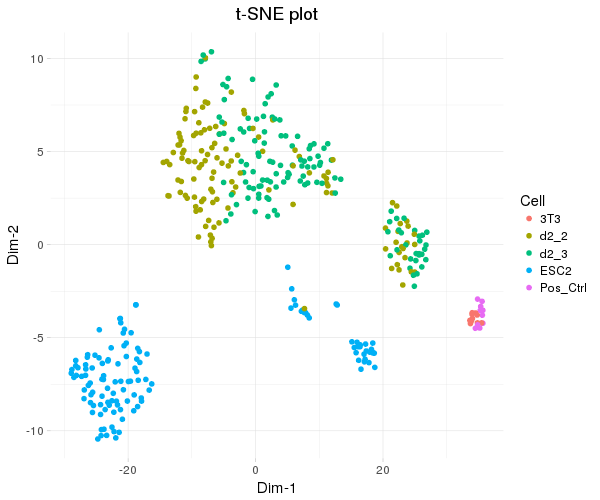

In [201]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)

df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2],Cell=Status)
p1<-ggplot(df, aes_string(x="X",y ="Y",color="Cell"))
p1<-p1 + ggtitle("t-SNE plot")
p1<-p1 + geom_point(size = 2)
p1<-p1 + xlab(paste("Dim-1"))
p1<-p1 + ylab("Dim-2")+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

## Obervations

- I cannot run my usual cell-based QC test as my pipeline is written for Genes and the data we have here are transcripts. I would need to adapt my pipeline for that.
- No cell/transcript filtering was done based on number of transcripts. Could be that it is __NOT__ necessary to have this filtering, but it is too early to comment on that.
- Surely need to run the pipeline with mapping with the genome to extract the genes

## Now converting the transcript counts to Gene Counts using `tximport`

The transcript counts are given in this worklow are given in different direction than the tximport would accept. It has cell names in rows and transcipt names in columns. we will tranpose it so that cell-name goes to columns and transcipt names go to rows

In [15]:
%%R
genematrixGene <- t(genematrix)

In [16]:
%%R
genematrixGene[1:5,1:5]

               AACCAACCAAG AACCAACTCCG AACCATAAGTA AACCATCATAA AACCATTGGCT
NM_001001130.2           0           0           0           0           0
NM_001001144.3           0           0           0           0           0
NM_001001160.3           1           0           0           2           0
NM_001001176.2           0           0           0           0           0
NM_001001177.2           0           0           0           0           0


We now import the GeneIDs

In [17]:
%%R
library("biomaRt")
ensembl <-  useMart("ENSEMBL_MART_ENSEMBL", dataset = "mmusculus_gene_ensembl", host="www.ensembl.org")
values <- gsub("\\..*","",rownames(genematrixGene))
head(values)

[1] "NM_001001130" "NM_001001144" "NM_001001160" "NM_001001176" "NM_001001177"
[6] "NM_001001178"


In [18]:
%%R
length(values)

[1] 87501


In [19]:
%%R
#TxtToGene <- getBM(attributes=c("refseq_mrna", "mgi_symbol"), filters = "refseq_mrna", values = values, mart= ensembl)
Txtrefseqmrna <- getBM(attributes=c("refseq_mrna", "mgi_symbol"), 
                   filters = c("refseq_mrna"), 
                   values = values, mart= ensembl)
Txtrefseqmrnapre <- getBM(attributes=c("refseq_mrna_predicted", "mgi_symbol"), 
                   filters = c("refseq_mrna_predicted"), 
                   values = values, mart= ensembl)
Txtrefseqncrna <- getBM(attributes=c("refseq_ncrna", "mgi_symbol"), 
                   filters = c("refseq_ncrna"), 
                   values = values, mart= ensembl)
Txtrefseqncrnapred <- getBM(attributes=c( "refseq_ncrna_predicted", "mgi_symbol"), 
                   filters = c("refseq_ncrna_predicted"), 
                   values = values, mart= ensembl)

In [26]:
%%R
library(data.table)
allRefSeq <- rbindlist(list(Txtrefseqmrna, Txtrefseqmrnapre, Txtrefseqncrna, Txtrefseqncrnapred),use.names=FALSE)
tail(allRefSeq)

    refseq_mrna mgi_symbol
1:    XR_388287           
2:    XR_406789           
3:    XR_388308           
4: XR_001783128           
5:    XR_879495           
6: XR_001783131           


In [21]:
%%R
genematrixGeneNameMod <- as.data.frame(genematrixGene)
rownames(genematrixGeneNameMod) <- gsub("\\..*","",rownames(genematrixGeneNameMod))
#genematrixGeneNameMod$GENEID <- NA
genematrixGeneNameMod$refseq_mrna <- rownames(genematrixGeneNameMod)
#write.csv(genematrixGeneNameMod, 'genematrixGeneNameMod.tsv', sep='\t')

In [22]:
%%R
tx2gene <- data.frame(TXNAME = allRefSeq[,1], GENEID = allRefSeq[,2])
head(tx2gene)

   refseq_mrna mgi_symbol
1    NM_027496   Ankrd33b
2    NM_026153   Ankrd33b
3 NM_001164441   Ankrd33b
4    NM_020581    Angptl4
5    NM_010849        Myc
6 NM_001177353        Myc


In [23]:
%%R
cdWithGeneID <- merge(tx2gene, genematrixGeneNameMod, by ="refseq_mrna")  
cdWithGeneID$refseq_mrna <- NULL

In [24]:
%%R
geneCount <- aggregate(. ~ mgi_symbol,data=cdWithGeneID, sum )  

In [25]:
%%R
dim(geneCount)

[1] 22648   396


In [27]:
%%R
geneCount <- geneCount[-1,]
rownames(geneCount) <- geneCount$mgi_symbol
geneCount$mgi_symbol<-NULL
head(geneCount)

              AACCAACCAAG AACCAACTCCG AACCATAAGTA AACCATCATAA AACCATTGGCT
0610007P14Rik           0           0           0           0           0
0610009B22Rik           0           4           0           0           0
0610009O20Rik           0         112           0           1           4
0610010F05Rik           0           1           0           1           0
0610010K14Rik           0           0           0           0           0
0610030E20Rik           1           0           0           0           0
              AACCGAATCTC AACCGAGAATT AACCGCTCATT AACCTAACGAG AACCTAGCGCT
0610007P14Rik           3           5           9           0           0
0610009B22Rik           0           0         216           0           6
0610009O20Rik           0           0           2           0           0
0610010F05Rik           0           0           2           0           0
0610010K14Rik           1           1         310           1           7
0610030E20Rik           0           1 

In [28]:
%%R
cd <- t(geneCount)
dim(cd)

[1]   395 22647


In [176]:
%%R
cd <- t(geneCount)
cd_orig <- cd
cd <- cd_orig[as.character(report_sub$Barcode),,drop=F]
dim(cd)

[1]   395 22647


In [33]:
%%R
head(cd_cpm)
#genematrix <- genematrix_orig[as.character(report_sub$Barcode),,drop=F]

            0610007P14Rik 0610009B22Rik 0610009O20Rik 0610010F05Rik
AACCAACCAAG       0.00000       0.00000      0.000000      0.000000
AACCAACTCCG       0.00000      28.17834    788.993540      7.044585
AACCATAAGTA       0.00000       0.00000      0.000000      0.000000
AACCATCATAA       0.00000       0.00000      8.292149      8.292149
            0610010K14Rik 0610030E20Rik 0610031O16Rik 0610037L13Rik
AACCAACCAAG       0.00000       17.5679             0         0.000
AACCAACTCCG       0.00000        0.0000             0         0.000
AACCATAAGTA       0.00000        0.0000             0         0.000
AACCATCATAA       0.00000        0.0000             0       447.776
            0610038B21Rik 0610039K10Rik 0610040F04Rik 0610040J01Rik
AACCAACCAAG             0       17.5679       0.00000             0
AACCAACTCCG             0        0.0000       0.00000             0
AACCATAAGTA             0        0.0000      31.49904             0
AACCATCATAA             0        0.0000       0.

In [106]:
%%R
norm_factor_cpm <- rowSums(cd) / 1000000
cd_cpm <- cd / norm_factor_cpm
write.csv(t(cd_cpm),'NormalizedGeneCounts.csv')

Now we remove all the positive controls

In [46]:
%%R
report_sub <- report_sub[!(report_sub$Type %in% c("Pos_Ctrl")),]
report_sub <- droplevels(report_sub)
report_sub <- report_sub[!(report_sub$Type %in% c("3T3")),]
report_sub <- droplevels(report_sub)

In [49]:
%%R
dim(report_sub)

[1] 375  30


In [48]:
%%R
cd_cntr_rem_cpm <- cd_cpm[rownames(cd_cpm) %in% report_sub$Barcode,]
cd_cntr_rem_cpm_log <- log2(cd_cntr_rem_cpm+1)
dim(cd_cntr_rem_cpm_log)

[1]   375 22647


Below we still continue to do the PCA with the controls. The positive controls that we removed would be used for differential expression later on.

In [50]:
%%R
cd_cpm_log2plus1 <- log2(cd_cpm+1)

In [312]:
%%R
FinalPCAData <- cd_cpm_log2plus1
pcaPRComp <- prcomp(FinalPCAData)

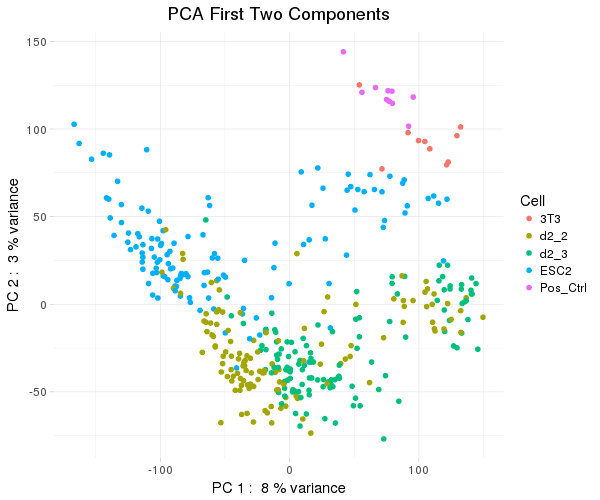

In [313]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)
PCx=1
PCy=2

percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA First Two Components")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

In [315]:
%%R
nmax = 10
if(dim(pcaPRComp$x)[1] < 10){ nmax = dim(pcaPRComp$x)[1] }
txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
pca_var = pcaPRComp$sdev ^ 2
pca_var_percent <- 100 * pca_var / sum(pca_var)
pca_var_percent_first10 <- NA * pca_var
pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

pca_corr_reads <- apply(pcaPRComp$x,2,function(x) cor(x,report_sub$Assigned))
    
pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1),round(pca_corr_reads,3))
rownames(pca_var_out) <- colnames(pcaPRComp$x)
colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1,"PC_Corr_AssignedReads")

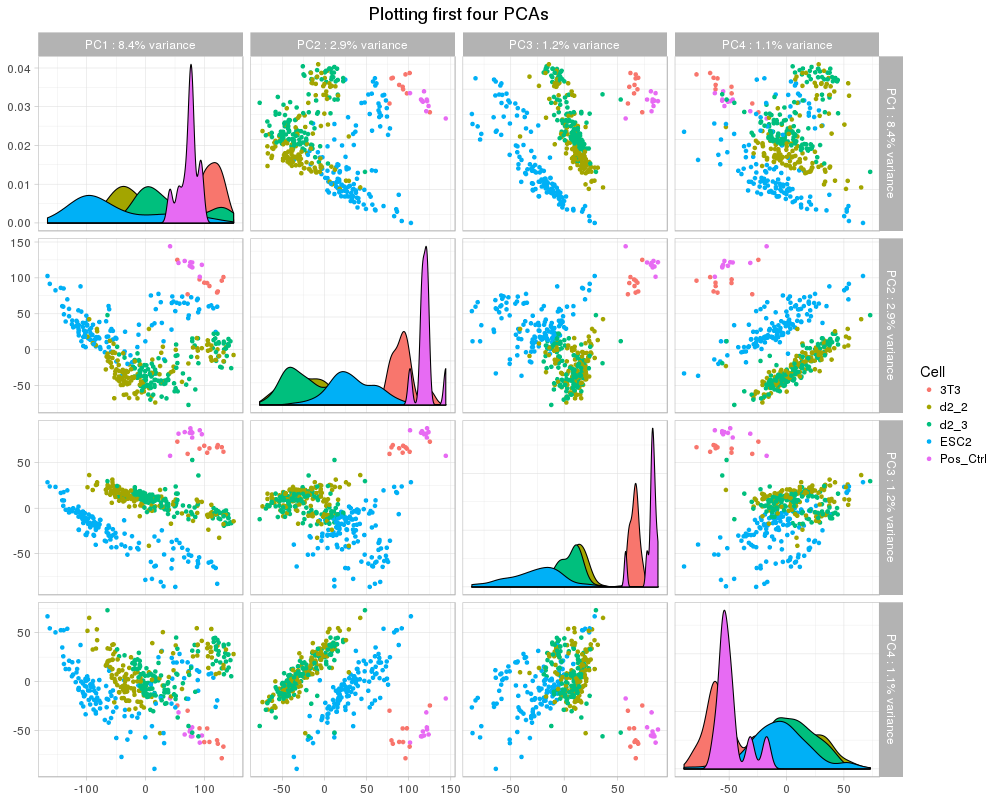

In [318]:
%%R -w 1000 -h 800
# Set the number of columns you like to display
nColToDisplay = 4
df <- as.data.frame(pcaPRComp$x)
df$Cell=Status
p <- ggpairs(df, columns=1:nColToDisplay, upper=list(continuous="points"), 
             title='Plotting first four PCAs', 
             mapping = aes_string(color="Cell"),
             legend = c(1,nColToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nColToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nColToDisplay], '% variance')))+
    theme_light(base_size=15)+     
    theme(plot.title = element_text(hjust = 0.5))
    
print(p)

In [338]:
%%R
nmax = 10
if(dim(pcaPRComp$x)[1] < 10){ nmax = dim(pcaPRComp$x)[1] }
txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
pca_var = pcaPRComp$sdev ^ 2
pca_var_percent <- 100 * pca_var / sum(pca_var)
pca_var_percent_first10 <- NA * pca_var
pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

pca_corr_reads <- apply(pcaPRComp$x,2,function(x) cor(x,report_sub$Assigned))
    
pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1),round(pca_corr_reads,3))
rownames(pca_var_out) <- colnames(pcaPRComp$x)
colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1,"PC_Corr_AssignedReads")

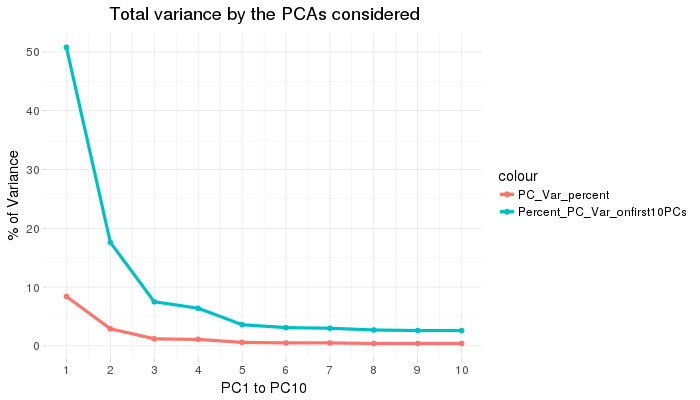

In [339]:
%%R -w 700 -h 400
p <- ggplot(pca_var_out[1:10,])
p <- p + geom_line(aes(x=c(1:10), y = PC_Var_percent, color="PC_Var_percent"), size=1.5)+
         geom_point(aes(x=c(1:10), y = PC_Var_percent, color="PC_Var_percent"), size = 2)+
         geom_line(aes(x=c(1:10), y = Percent_PC_Var_onfirst10PCs, color="Percent_PC_Var_onfirst10PCs"), size=1.5)+
         geom_point(aes(x=c(1:10), y = Percent_PC_Var_onfirst10PCs, color="Percent_PC_Var_onfirst10PCs"), size = 2)+
         ggtitle("Total variance by the PCAs considered")+
         xlab(paste("PC1 to PC10"))+
         ylab(paste("% of Variance"))+     
         theme_light(base_size=15)+     
         theme(plot.title = element_text(hjust = 0.5),
              panel.border     = element_blank())+
         scale_x_continuous(breaks=c(1:10))
print(p)

In [340]:
%%R
rtsne_pca_out <- Rtsne(as.matrix(pcaPRComp$x[,1:6]))

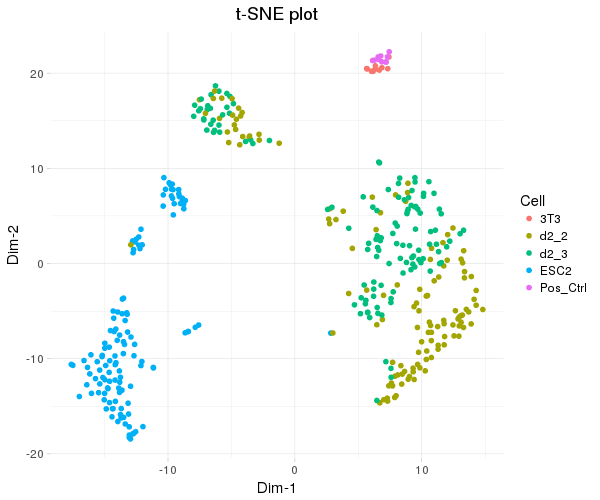

In [341]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)

df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2],Cell=Status)
p1<-ggplot(df, aes_string(x="X",y ="Y",color="Cell"))
p1<-p1 + ggtitle("t-SNE plot")
p1<-p1 + geom_point(size = 2)
p1<-p1 + xlab(paste("Dim-1"))
p1<-p1 + ylab("Dim-2")+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

## Filtering the cells

In [102]:
%%R
cdFiltered <- clean.counts(t(cd_cpm), min.lib.size=1800, min.reads = 50, min.detected = 20)
print(paste0("Before Filtering: ", dim(t(cd_cpm))))
print(paste0("After Filtering: ", dim(cdFiltered)))

[1] "Before Filtering: 22647" "Before Filtering: 395"  
[1] "After Filtering: 16873" "After Filtering: 386"  


In [363]:
%%R
report_sub <- report_sub[report_sub$Barcode %in% colnames(cdFiltered),]
length(report_sub$Type)

[1] 386


In [365]:
%%R
cd_cpm_log2plus1 <- log2(cdFiltered+1)
FinalPCAData <- t(cd_cpm_log2plus1)
pcaPRComp <- prcomp(FinalPCAData)

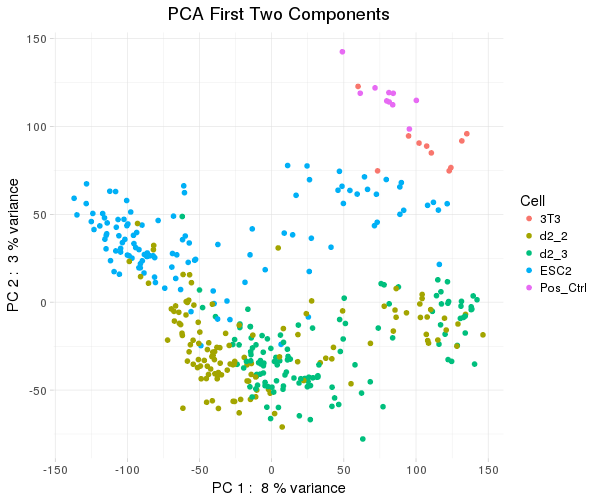

In [366]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)
PCx=1
PCy=2

percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA First Two Components")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)


In [367]:
%%R
nmax = 10
if(dim(pcaPRComp$x)[1] < 10){ nmax = dim(pcaPRComp$x)[1] }
txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
pca_var = pcaPRComp$sdev ^ 2
pca_var_percent <- 100 * pca_var / sum(pca_var)
pca_var_percent_first10 <- NA * pca_var
pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

pca_corr_reads <- apply(pcaPRComp$x,2,function(x) cor(x,report_sub$Assigned))
    
pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1),round(pca_corr_reads,3))
rownames(pca_var_out) <- colnames(pcaPRComp$x)
colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1,"PC_Corr_AssignedReads")


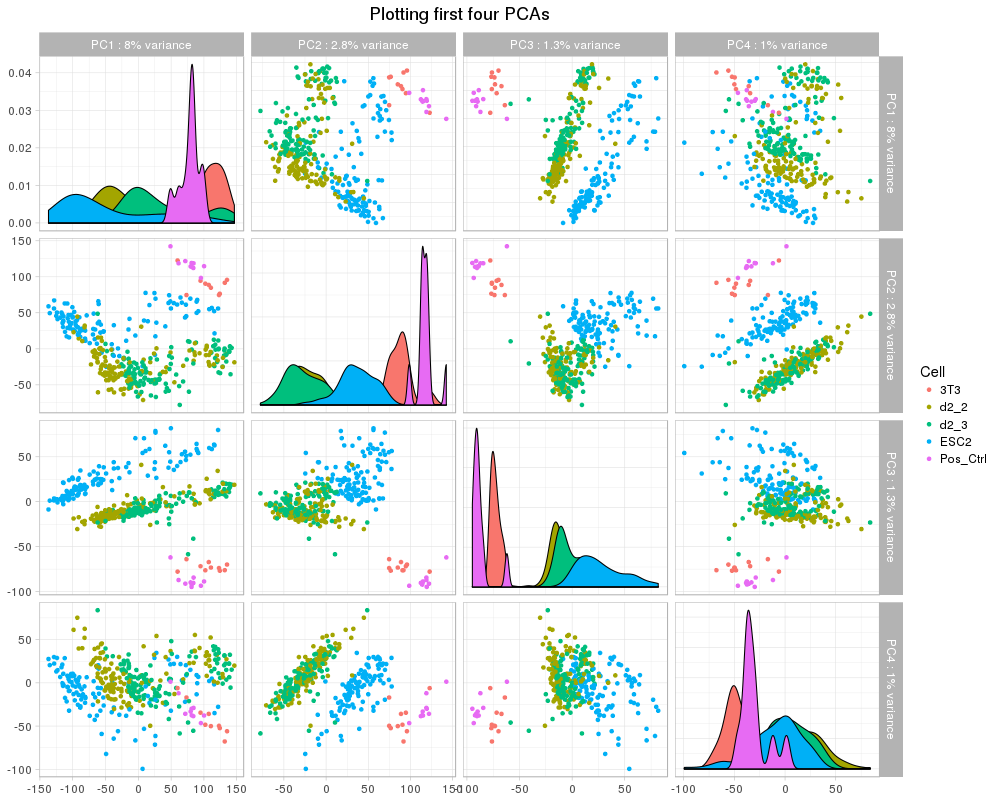

In [370]:
%%R -w 1000 -h 800
# Set the number of columns you like to display
nColToDisplay = 4
df <- as.data.frame(pcaPRComp$x)
df$Cell=Status
p <- ggpairs(df, columns=1:nColToDisplay, upper=list(continuous="points"), 
             title='Plotting first four PCAs', 
             mapping = aes_string(color="Cell"),
             legend = c(1,nColToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nColToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nColToDisplay], '% variance')))+
    theme_light(base_size=15)+     
    theme(plot.title = element_text(hjust = 0.5))
    
print(p)

In [371]:
%%R
nmax = 10
if(dim(pcaPRComp$x)[1] < 10){ nmax = dim(pcaPRComp$x)[1] }
txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
pca_var = pcaPRComp$sdev ^ 2
pca_var_percent <- 100 * pca_var / sum(pca_var)
pca_var_percent_first10 <- NA * pca_var
pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

pca_corr_reads <- apply(pcaPRComp$x,2,function(x) cor(x,report_sub$Assigned))
    
pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1),round(pca_corr_reads,3))
rownames(pca_var_out) <- colnames(pcaPRComp$x)
colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1,"PC_Corr_AssignedReads")



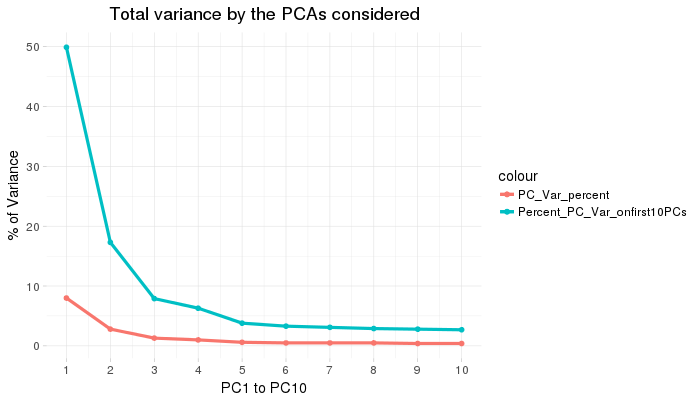

In [372]:
%%R -w 700 -h 400
p <- ggplot(pca_var_out[1:10,])
p <- p + geom_line(aes(x=c(1:10), y = PC_Var_percent, color="PC_Var_percent"), size=1.5)+
         geom_point(aes(x=c(1:10), y = PC_Var_percent, color="PC_Var_percent"), size = 2)+
         geom_line(aes(x=c(1:10), y = Percent_PC_Var_onfirst10PCs, color="Percent_PC_Var_onfirst10PCs"), size=1.5)+
         geom_point(aes(x=c(1:10), y = Percent_PC_Var_onfirst10PCs, color="Percent_PC_Var_onfirst10PCs"), size = 2)+
         ggtitle("Total variance by the PCAs considered")+
         xlab(paste("PC1 to PC10"))+
         ylab(paste("% of Variance"))+     
         theme_light(base_size=15)+     
         theme(plot.title = element_text(hjust = 0.5),
              panel.border     = element_blank())+
         scale_x_continuous(breaks=c(1:10))
print(p)

In [373]:
%%R
rtsne_pca_out <- Rtsne(as.matrix(pcaPRComp$x[,1:6]))

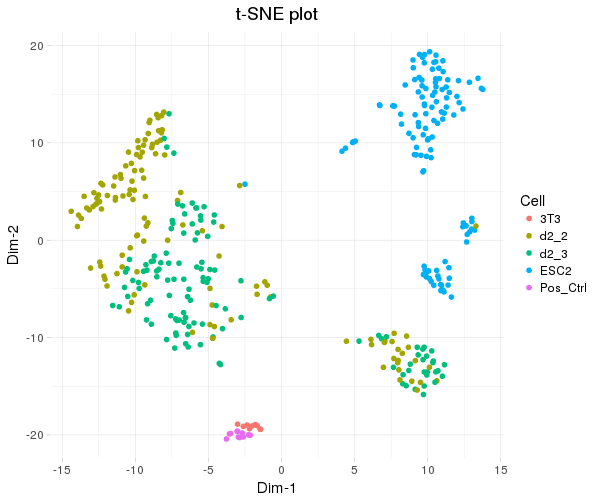

In [375]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)

df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2],Cell=Status)
p1<-ggplot(df, aes_string(x="X",y ="Y",color="Cell"))
p1<-p1 + ggtitle("t-SNE plot")
p1<-p1 + geom_point(size = 2)
p1<-p1 + xlab(paste("Dim-1"))
p1<-p1 + ylab("Dim-2")+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)


In [64]:
%%R
FinalPCAData <- cd_cntr_rem_cpm_log
pcaPRComp <- prcomp(FinalPCAData)

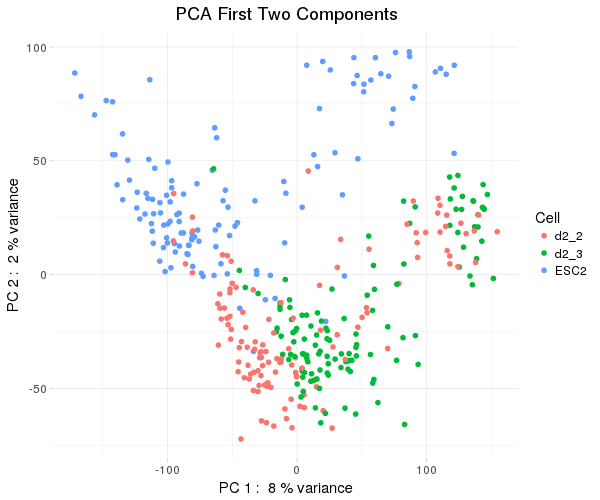

In [65]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)
PCx=1
PCy=2

percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA First Two Components")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)


In [66]:
%%R
nmax = 10
if(dim(pcaPRComp$x)[1] < 10){ nmax = dim(pcaPRComp$x)[1] }
txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
pca_var = pcaPRComp$sdev ^ 2
pca_var_percent <- 100 * pca_var / sum(pca_var)
pca_var_percent_first10 <- NA * pca_var
pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

pca_corr_reads <- apply(pcaPRComp$x,2,function(x) cor(x,report_sub$Assigned))
    
pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1),round(pca_corr_reads,3))
rownames(pca_var_out) <- colnames(pcaPRComp$x)
colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1,"PC_Corr_AssignedReads")



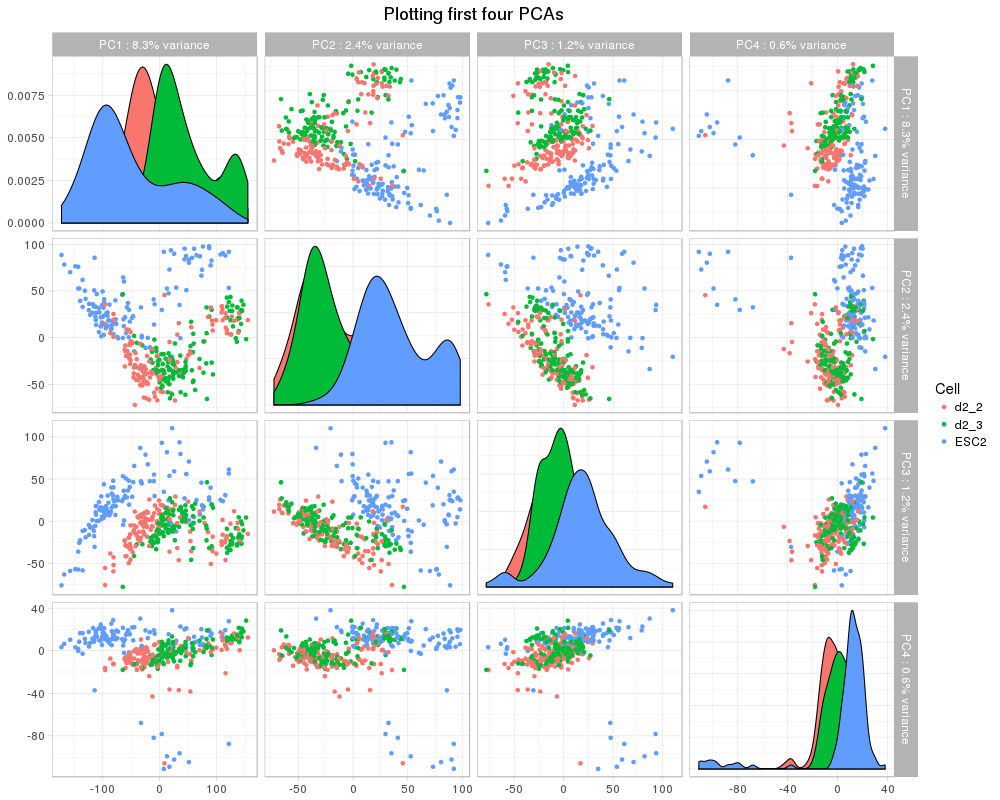

In [67]:
%%R -w 1000 -h 800
# Set the number of columns you like to display
nColToDisplay = 4
df <- as.data.frame(pcaPRComp$x)
df$Cell=Status
p <- ggpairs(df, columns=1:nColToDisplay, upper=list(continuous="points"), 
             title='Plotting first four PCAs', 
             mapping = aes_string(color="Cell"),
             legend = c(1,nColToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nColToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nColToDisplay], '% variance')))+
    theme_light(base_size=15)+     
    theme(plot.title = element_text(hjust = 0.5))
    
print(p)

In [71]:
%%R
rtsne_pca_out <- Rtsne(as.matrix(pcaPRComp$x[,1:6]))

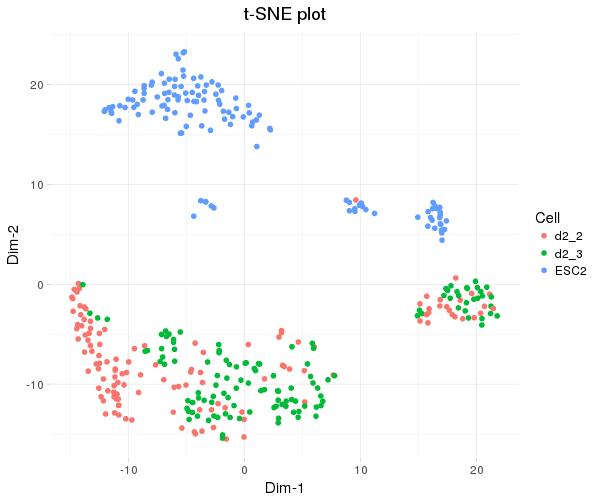

In [72]:
%%R -w 600 -h 500
sampleCondition <- report_sub$Type
Status <- as.factor(sampleCondition)

df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2],Cell=Status)
p1<-ggplot(df, aes_string(x="X",y ="Y",color="Cell"))
p1<-p1 + ggtitle("t-SNE plot")
p1<-p1 + geom_point(size = 2)
p1<-p1 + xlab(paste("Dim-1"))
p1<-p1 + ylab("Dim-2")+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

In [98]:
%%R
cd_cntr_rem_cpm_Filtered <- clean.counts(t(cd_cntr_rem_cpm), min.lib.size=1800, min.reads = 50, min.detected = 20)
print(paste0("Before Filtering: ", dim(t(cd_cntr_rem_cpm))))
print(paste0("After Filtering: ", dim(cd_cntr_rem_cpm_Filtered)))

[1] "Before Filtering: 22647" "Before Filtering: 375"  
[1] "After Filtering: 16475" "After Filtering: 366"  


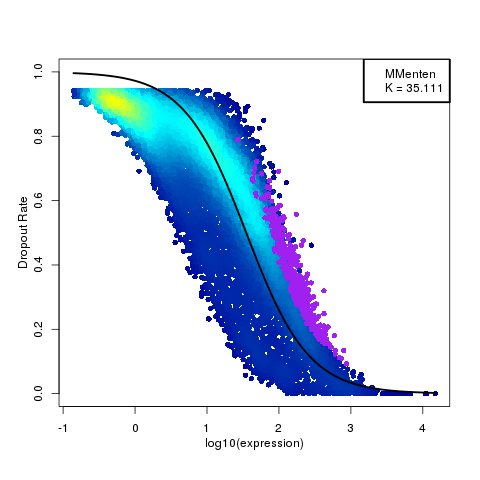

In [99]:
%%R
DiffGenes<- M3DropDifferentialExpression(cd_cntr_rem_cpm_Filtered,mt_threshold=0.05)

In [100]:
%%R
dim(DiffGenes)

[1] 391   3


In [101]:
%%R
DiffGenesOrdered <- DiffGenes
DiffGenesOrdered <- DiffGenesOrdered[order(DiffGenesOrdered$q.value, decreasing=FALSE),]
write.csv(DiffGenesOrdered, 'DiffGenesICELL8.csv', row.names=FALSE)

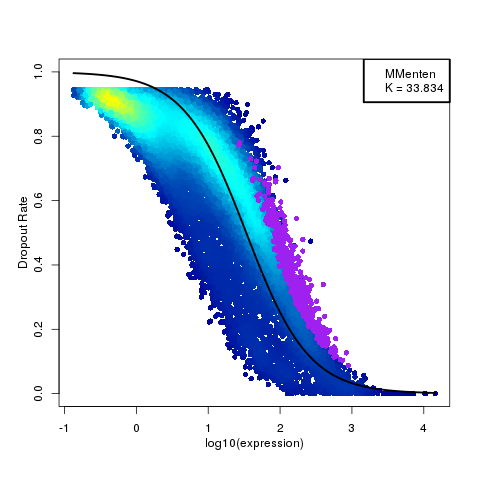

In [103]:
%%R
DiffGenesWithControls <- M3DropDifferentialExpression(cdFiltered,mt_threshold=0.05)

In [104]:
%%R
dim(DiffGenesWithControls)

[1] 470   3


In [105]:
%%R
DiffGenesOrdered <- DiffGenesWithControls
DiffGenesOrdered <- DiffGenesOrdered[order(DiffGenesOrdered$q.value, decreasing=FALSE),]
write.csv(DiffGenesOrdered, 'DiffGenesWithControlsICELL8.csv', row.names=FALSE)

In [112]:
%%R -w 1000 -h 1000
#c('nanog','klf4','sox2','esrrb')
#M3DropExpressionHeatmap(rownames(cdFiltered), cdFiltered, key_genes=c('Nanog'))

NULL


In [113]:
%%R
report <- read.csv(file="sce-1059_mm_refseq_merged.report.csv",skip=8)
#Check for and separate UNION row
if(as.character(report[dim(report)[1],1]) == 'UNION'){
  union <- report[dim(report)[1],]
  union <- droplevels(union)
  report <- report[1:((dim(report)[1]) -1),]
  report <- droplevels(report)
}
report_sub <- report[!(report$Type %in% c("Neg_Ctrl")),]
report_sub <- droplevels(report_sub)

In [237]:
%%R
cdAmang <- as.data.frame(cd)
rownames(cdAmang) <- paste0(report_sub$Type[rownames(cdAmang) %in% report_sub$Barcode], '_',rownames(cdAmang))

In [238]:
%%R
dim(cdAmang)

[1]   395 22647


In [240]:
%%R
#cdAllAmangCount <- aggregate(. ~ Type,data=cdAmang, sum )  

NULL


In [223]:
%%R
rownames(cdAllAmangCount) <- cdAllAmangCount$Type
#cdAllAmangCount <- cdAllAmangCount[-1,]
cdAllAmangCount$Type<-NULL
droplevels(cdAllAmangCount)
cdAllAmangCount[,1:2]
#head(cdThreeAmangCount)

         0610007P14Rik 0610009B22Rik
3T3               1963          1738
d2_2              5815          6634
d2_3              7170          8876
ESC2              2859          4868
Pos_Ctrl          6440           962


In [241]:
%%R
cdAllCountTrans <- t(cdAmang)
head(cdAllCountTrans)
write.csv(cdAllCountTrans,'cdAllCountTransWithAllCells.csv')

In [10]:
%%R
cdAllCountTrans <- read.csv('cdAllCountTransWithAllCells.csv',row.names=1)

In [24]:
%%R
cdAllCountsFiltered <- clean.counts(cdAllCountTrans, min.lib.size=1800, min.reads = 50, min.detected = 20)

In [25]:
%%R
# factor determining cell types
sg <- factor(gsub("(3T3|d2_2|d2_3|ESC2|Pos_Ctrl).*", "\\1", report_sub$Type), levels = c("3T3","d2_2","d2_3","ESC2","Pos_Ctrl"))
# the group factor should be named accordingly
names(sg) <- colnames(report_sub$Type)  
table(sg)

sg
     3T3     d2_2     d2_3     ESC2 Pos_Ctrl 
      10      125      125      125       10 


### Starting DESEQ-2

In [26]:
%%R
#cdAllAmangCountTransNoOfCellNorm <- cbind(round(cdAllCountTrans [,1]/as.data.frame(table(sg))$Freq[1]),
#                                            round(cdAllCountTrans [,2]/as.data.frame(table(sg))$Freq[2]),
#                                            round(cdAllCountTrans [,3]/as.data.frame(table(sg))$Freq[3]),
#                                            round(cdAllCountTrans [,4]/as.data.frame(table(sg))$Freq[4]),
#                                            round(cdAllCountTrans [,5]/as.data.frame(table(sg))$Freq[5]))
#colnames(cdAllAmangCountTransNoOfCellNorm) <- colnames(cdAllCountTrans )
#head(cdAllAmangCountTransNoOfCellNorm)
colnames(cdAllCountsFiltered)


  [1] "ESC2_AACCAACCAAG"     "ESC2_AACCAACTCCG"     "ESC2_AACCATAAGTA"    
  [4] "ESC2_AACCATCATAA"     "ESC2_AACCATTGGCT"     "ESC2_AACCGAATCTC"    
  [7] "ESC2_AACCGAGAATT"     "ESC2_AACCGCTCATT"     "ESC2_AACCTAACGAG"    
 [10] "ESC2_AACCTAGCGCT"     "ESC2_AACCTCCAATA"     "Pos_Ctrl_AACCTCCGTCC"
 [13] "ESC2_AACCTGGCTCC"     "ESC2_AACGAACGCTC"     "ESC2_AACGAGACCGA"    
 [16] "ESC2_AACGAGAGGAA"     "ESC2_AACGATAGCAT"     "ESC2_AACGATATATC"    
 [19] "Pos_Ctrl_AACGATCCAGC" "ESC2_AACGCATACTC"     "ESC2_AACGCCAGGCT"    
 [22] "ESC2_AACGCCTATAA"     "ESC2_AACGCGCGCAA"     "ESC2_AACGCTTCGTT"    
 [25] "ESC2_AACGGAACGTT"     "ESC2_AACGGACGCAG"     "ESC2_AACGGAGACGT"    
 [28] "Pos_Ctrl_AACGGATCAAT" "ESC2_AACGGCAGGAG"     "ESC2_AACGGCATAAT"    
 [31] "ESC2_AACGGCGTCGA"     "ESC2_AACGGTCAAGT"     "ESC2_AACGTACCTGA"    
 [34] "ESC2_AACGTAGCGTC"     "ESC2_AACGTCAATAT"     "ESC2_AACGTCATTGG"    
 [37] "ESC2_AACGTCCTAGT"     "ESC2_AACGTCTCATA"     "ESC2_AACGTTAACTT"    
 [40] "ESC2_AACTAACGTCA" 

In [36]:
%%R
countsTable <- cdAllCountsFiltered
celltype <- factor(gsub("(X3T3|d2_2|d2_3|ESC2|Pos_Ctrl).*", "\\1", colnames(cdAllCountsFiltered)), levels=c('ESC2','Pos_Ctrl','d2_2', 'd2_3', 'X3T3'), labels=c('ESC2','Pos_Ctrl','d2_2', 'd2_3', 'X3T3'))
myNames <- colnames(cdAllCountsFiltered)
colDataNames<-data.frame(sampleName=myNames, celltype=celltype)

In [28]:
%%R
t1 <- cdAllCountsFiltered[,gsub("(3T3|d2_2|d2_3|ESC2|Pos_Ctrl).*", "\\1", colnames(cdAllCountsFiltered)) == 'd2_2']
t2 <- cdAllCountsFiltered[,gsub("(3T3|d2_2|d2_3|ESC2|Pos_Ctrl).*", "\\1", colnames(cdAllCountsFiltered)) == 'ESC2']
forDE <- cbind(t1,t2)
#colnames(forDE)

First we are doing DE between __d2_2__ and __ESC2__

In [269]:
%%R
countsTableTrim <- forDE
celltype <- factor(gsub("(d2_2|ESC2).*", "\\1", colnames(forDE)),levels=c("d2_2", "ESC2"))
myNames <- colnames(forDE)
colDataNames<-data.frame(sampleName=myNames, celltype=celltype)
des<-formula(~celltype)
DESeqDataSet
ddsHTSeq<-DESeqDataSetFromMatrix(countsTableTrim, colData=colDataNames, design=des, ignoreRank = FALSE)
ddsHTSeq<-DESeq(ddsHTSeq,betaPrior=FALSE)
#look at contrasts done
resultsNames(ddsHTSeq)

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: -- replacing outliers and refitting for 8941 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  warnings.warn(x, RRuntimeWarning)


[1] "Intercept"             "celltype_ESC2_vs_d2_2"


In [270]:
%%R
res=results (ddsHTSeq, name="celltype_ESC2_vs_d2_2", independentFiltering = FALSE)
write.csv(res,"DESeq_celltype_ESC2_vs_d2_2_unpaired.csv")

In [271]:
%%R
t1 <- cdAllCountsFiltered[,gsub("(3T3|d2_2|d2_3|ESC2|Pos_Ctrl).*", "\\1", colnames(cdAllCountsFiltered)) == 'd2_3']
t2 <- cdAllCountsFiltered[,gsub("(3T3|d2_2|d2_3|ESC2|Pos_Ctrl).*", "\\1", colnames(cdAllCountsFiltered)) == 'ESC2']
forDE <- cbind(t1,t2)

In [272]:
%%R
countsTableTrim <- forDE
celltype <- factor(gsub("(d2_3|ESC2).*", "\\1", colnames(forDE)),levels=c("d2_3", "ESC2"))
myNames <- colnames(forDE)
colDataNames<-data.frame(sampleName=myNames, celltype=celltype)
des<-formula(~celltype)
DESeqDataSet
ddsHTSeq<-DESeqDataSetFromMatrix(countsTableTrim, colData=colDataNames, design=des, ignoreRank = FALSE)
ddsHTSeq<-DESeq(ddsHTSeq,betaPrior=FALSE)
#look at contrasts done
resultsNames(ddsHTSeq)

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: -- replacing outliers and refitting for 9134 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  warnings.warn(x, RRuntimeWarning)


[1] "Intercept"             "celltype_ESC2_vs_d2_3"


In [273]:
%%R
res=results (ddsHTSeq, name="celltype_ESC2_vs_d2_3", independentFiltering = FALSE)
write.csv(res,"DESeq_celltype_ESC2_vs_d2_3_unpaired.csv")

In [274]:
%%R
t1 <- cdAllCountsFiltered[,gsub("(3T3|d2_2|d2_3|ESC2|Pos_Ctrl).*", "\\1", colnames(cdAllCountsFiltered)) == 'd2_2']
t2 <- cdAllCountsFiltered[,gsub("(3T3|d2_2|d2_3|ESC2|Pos_Ctrl).*", "\\1", colnames(cdAllCountsFiltered)) == 'd2_3']
forDE <- cbind(t1,t2)

In [275]:
%%R
countsTableTrim <- forDE
celltype <- factor(gsub("(d2_2|d2_3).*", "\\1", colnames(forDE)),levels=c("d2_2", "d2_3"))
myNames <- colnames(forDE)
colDataNames<-data.frame(sampleName=myNames, celltype=celltype)
des<-formula(~celltype)
DESeqDataSet
ddsHTSeq<-DESeqDataSetFromMatrix(countsTableTrim, colData=colDataNames, design=des, ignoreRank = FALSE)
ddsHTSeq<-DESeq(ddsHTSeq,betaPrior=FALSE)
#look at contrasts done
resultsNames(ddsHTSeq)

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: -- replacing outliers and refitting for 8953 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  warnings.warn(x, RRuntimeWarning)


[1] "Intercept"             "celltype_d2_3_vs_d2_2"


In [276]:
%%R
res=results (ddsHTSeq, name="celltype_d2_3_vs_d2_2", independentFiltering = FALSE)
write.csv(res,"DESeq_celltype_d2_3_vs_d2_2_unpaired.csv")

In [185]:
%%R
report <- read.csv(file="sce-1059_mm_refseq_merged.report.csv",skip=8)
#genematrix <- read.table(file="sce-1059_mm_refseq.genematrix_sansUMI.csv", sep=",")
if(as.character(report[dim(report)[1],1]) == 'UNION'){
  union <- report[dim(report)[1],]
  union <- droplevels(union)
  report <- report[1:((dim(report)[1]) -1),]
  report <- droplevels(report)
}
report_sub <- report[!(report$Type %in% c("Neg_Ctrl")),]
report_sub <- droplevels(report_sub)

In [186]:
%%R
cd <- read.csv('cdAllCountTransWithAllCells.csv',row.names=1)

In [187]:
%%R
cdSelect <- cd[,gsub(".*_","",colnames(cd)) %in% report_sub$Barcode]
cdAllCountsFiltered <- clean.counts(cdSelect, min.lib.size=1800, min.reads = 50, min.detected = 20)

In [188]:
%%R
cd_cpm_log2plus1 <- log2(cdAllCountsFiltered+1)
FinalPCAData <- t(cd_cpm_log2plus1)
pcaPRComp <- prcomp(FinalPCAData)

In [194]:
%%R
# factor determining cell types
sg <- factor(gsub("(X3T3|d2_2|d2_3|ESC2|Pos_Ctrl).*", "\\1", colnames(cd_cpm_log2plus1)), levels = c("X3T3","d2_2","d2_3","ESC2","Pos_Ctrl"))
# the group factor should be named accordingly
names(sg) <- colnames(report_sub$Type)  
table(sg)

sg
    X3T3     d2_2     d2_3     ESC2 Pos_Ctrl 
      10      125      125      116       10 


In [195]:
%%R
celltype <- factor(gsub("(X3T3|d2_2|d2_3|ESC2|Pos_Ctrl).*", "\\1", colnames(cdAllCountsFiltered)), levels=c('ESC2','Pos_Ctrl','d2_2', 'd2_3', 'X3T3'), labels=c('ESC2','Pos_Ctrl','d2_2', 'd2_3', 'X3T3'))

In [221]:
%%R
rtsne_pca_out <- Rtsne(as.matrix(pcaPRComp$x[,1:6]))

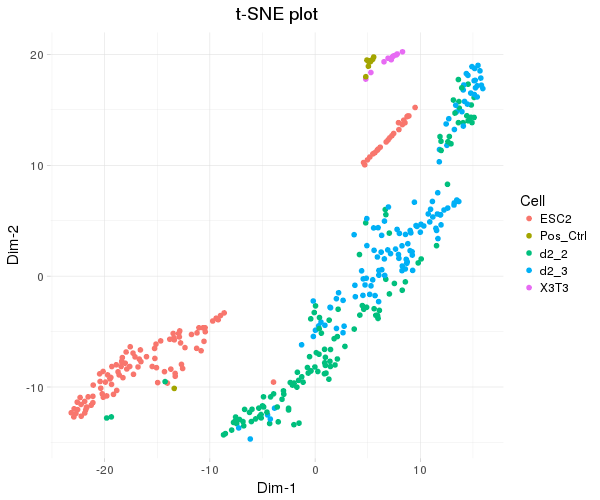

In [229]:
%%R -w 600 -h 500
sampleCondition <- celltype
Status <- as.factor(sampleCondition)

df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2],Cell=Status, cellName=colnames(cdAllCountsFiltered))
p1<-ggplot(df, aes_string(x="X",y ="Y",color="Cell"))
p1<-p1 + ggtitle("t-SNE plot")
p1<-p1 + geom_point(size = 2)
p1<-p1 + xlab(paste("Dim-1"))
p1<-p1 + ylab("Dim-2")+
    theme_light(base_size=15) +
    theme(strip.background = element_blank(),
          panel.border     = element_blank(),
          plot.title = element_text(hjust = 0.5))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

In [260]:
%%R
#df
g1CellName <- df[(df$X<=-7 & df$Y<=-1),]$cellName
g1CellName <- g1CellName[g1CellName != 'Pos_Ctrl_GAACTCGTCGT']
g1CellName <- droplevels(g1CellName)
g2CellName <- df[((df$X>=0 & df$X<=10) & (df$Y>=9 & df$Y<= 13)),]$cellName
g3CellName <- df[(df$X>=-10),]$cellName
g3CellName <- g3CellName[gsub("(3T3|d2_2|d2_3|ESC2|Pos_Ctrl).*", "\\1", g3CellName)!="ESC2"]
g3CellName <- g3CellName[gsub("(3T3|d2_2|d2_3|Pos_Ctrl).*", "\\1", g3CellName)!="Pos_Ctrl"]
g3CellName <- g3CellName[gsub("(3T3|d2_2|d2_3).*", "\\1", g3CellName)!="X3T3"]


In [271]:
%%R
g4CellName <- df[((df$X>=10) & (df$Y>=10)),]$cellName
g5CellName <- df[((df$X> -10) & (df$Y<= 10)),]$cellName
g5CellName <- g5CellName[gsub("(3T3|d2_2|d2_3|ESC2|Pos_Ctrl).*", "\\1", g5CellName)!="ESC2"]

In [252]:
%%R
g1 <- cdAllCountsFiltered[,as.character(g1CellName)]
colnames(g1) <- paste0('g1_', colnames(g1))
g2 <- cdAllCountsFiltered[,as.character(g2CellName)]
colnames(g2) <- paste0('g2_', colnames(g2))
forDE <- cbind(g1,g2)

In [253]:
%%R
countsTableTrim <- forDE
celltype <- factor(gsub("(g1|g2).*", "\\1", colnames(forDE)),levels=c("g1", "g2"))
myNames <- colnames(forDE)
colDataNames<-data.frame(sampleName=myNames, celltype=celltype)
des<-formula(~celltype)
DESeqDataSet
ddsHTSeq<-DESeqDataSetFromMatrix(countsTableTrim, colData=colDataNames, design=des, ignoreRank = FALSE)
ddsHTSeq<-DESeq(ddsHTSeq,betaPrior=FALSE)
#look at contrasts done
resultsNames(ddsHTSeq)

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating size factors

  warnings.warn(x, RRuntimeWarning)
/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: estimating dispersions

  warnings.warn(x, RRuntimeWarning)
/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: gene-wise dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: mean-dispersion relationship

  warnings.warn(x, RRuntimeWarning)
/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: final dispersion estimates

  warnings.warn(x, RRuntimeWarning)
/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: fitting model and testing

  warnings.warn(x, RRuntimeWarning)
/home/baker/anacon

[1] "Intercept"         "celltype_g2_vs_g1"


In [254]:
%%R
res=results (ddsHTSeq, name="celltype_g2_vs_g1", independentFiltering = FALSE)
write.csv(res,"DESeq_celltype_g2_vs_g1_unpaired.csv")

In [261]:
%%R
g1 <- cdAllCountsFiltered[,as.character(g1CellName)]
colnames(g1) <- paste0('g1_', colnames(g1))
g3 <- cdAllCountsFiltered[,as.character(g3CellName)]
colnames(g3) <- paste0('g3_', colnames(g3))
forDE <- cbind(g1,g3)

In [262]:
%%R
countsTableTrim <- forDE
celltype <- factor(gsub("(g1|g3).*", "\\1", colnames(forDE)),levels=c("g1", "g3"))
myNames <- colnames(forDE)
colDataNames<-data.frame(sampleName=myNames, celltype=celltype)
des<-formula(~celltype)
DESeqDataSet
ddsHTSeq<-DESeqDataSetFromMatrix(countsTableTrim, colData=colDataNames, design=des, ignoreRank = FALSE)
ddsHTSeq<-DESeq(ddsHTSeq,betaPrior=FALSE)
#look at contrasts done
resultsNames(ddsHTSeq)

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: -- replacing outliers and refitting for 9518 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  warnings.warn(x, RRuntimeWarning)


[1] "Intercept"         "celltype_g3_vs_g1"


In [263]:
%%R
res=results (ddsHTSeq, name="celltype_g3_vs_g1", independentFiltering = FALSE)
write.csv(res,"DESeq_celltype_g3_vs_g1_unpaired.csv")

In [264]:
%%R
forDE <- cbind(g2,g3)

In [265]:
%%R
countsTableTrim <- forDE
celltype <- factor(gsub("(g2|g3).*", "\\1", colnames(forDE)),levels=c("g2", "g3"))
myNames <- colnames(forDE)
colDataNames<-data.frame(sampleName=myNames, celltype=celltype)
des<-formula(~celltype)
DESeqDataSet
ddsHTSeq<-DESeqDataSetFromMatrix(countsTableTrim, colData=colDataNames, design=des, ignoreRank = FALSE)
ddsHTSeq<-DESeq(ddsHTSeq,betaPrior=FALSE)
#look at contrasts done
resultsNames(ddsHTSeq)

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: -- replacing outliers and refitting for 7922 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

  warnings.warn(x, RRuntimeWarning)


[1] "Intercept"         "celltype_g3_vs_g2"


In [266]:
%%R
res=results (ddsHTSeq, name="celltype_g3_vs_g2", independentFiltering = FALSE)
write.csv(res,"DESeq_celltype_g3_vs_g2_unpaired.csv")

In [273]:
%%R
g4 <- cdAllCountsFiltered[,as.character(g4CellName)]
colnames(g4) <- paste0('g4_', colnames(g4))
g5 <- cdAllCountsFiltered[,as.character(g5CellName)]
colnames(g5) <- paste0( 'g5_' , colnames(g5))
forDE <- cbind(g4,g5)

In [277]:
%%R
countsTableTrim <- forDE
celltype <- factor(gsub("(g4|g5).*", "\\1", colnames(forDE)),levels=c("g4", "g5"))
myNames <- colnames(forDE)
colDataNames<-data.frame(sampleName=myNames, celltype=celltype)
des<-formula(~celltype)
DESeqDataSet
ddsHTSeq<-DESeqDataSetFromMatrix(countsTableTrim, colData=colDataNames, design=des, ignoreRank = FALSE)
ddsHTSeq<-DESeq(ddsHTSeq,betaPrior=FALSE)
#look at contrasts done
resultsNames(ddsHTSeq)


[1] "Intercept"         "celltype_g5_vs_g4"


In [278]:
%%R
res=results (ddsHTSeq, name="celltype_g5_vs_g4", independentFiltering = FALSE)
write.csv(res,"DESeq_celltype_g5_vs_g4_unpaired.csv")

In [276]:
%%R
write.csv(g1CellName, 'g1CellName.csv')
write.csv(g2CellName, 'g2CellName.csv')
write.csv(g3CellName, 'g3CellName.csv')
write.csv(g4CellName, 'g4CellName.csv')
write.csv(g5CellName, 'g5CellName.csv')

## Trying monocle-2 to analyze 

In [69]:
%%R
cellPhenoData <- data.frame(cells= colnames(cdAllCountsFiltered), celltype=celltype)
count_matrix <- cdAllCountsFiltered
geneNames <- rownames(cdAllCountsFiltered)

In [76]:
%%R
pd <- new("AnnotatedDataFrame", data = cellPhenoData)
rownames(pd) <- cellPhenoData$cells

In [63]:
%%R
fd <- new("AnnotatedDataFrame", data = as.data.frame(geneNames))
rownames(fd) <- fd$geneNames

In [79]:
%%R
ICELL8 <- newCellDataSet(as.matrix(count_matrix),
                              phenoData = pd,
                              featureData = fd,
                              expressionFamily=negbinomial())

In [92]:
%%R
ICELL8 <- estimateSizeFactors(ICELL8)
ICELL8 <- estimateDispersions(ICELL8)

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Removing 589 outliers

  warnings.warn(x, RRuntimeWarning)


In [107]:
%%R
ICELL8  <- detectGenes(ICELL8 , min_expr = 0.1)
print(head(fData(ICELL8)))
expressed_genes <- row.names(subset(fData(ICELL8), num_cells_expressed >= 20))

                  geneNames num_cells_expressed use_for_ordering
0610007P14Rik 0610007P14Rik                 223            FALSE
0610009B22Rik 0610009B22Rik                 186            FALSE
0610009O20Rik 0610009O20Rik                 135            FALSE
0610010F05Rik 0610010F05Rik                 107            FALSE
0610010K14Rik 0610010K14Rik                 233            FALSE
0610030E20Rik 0610030E20Rik                 205            FALSE


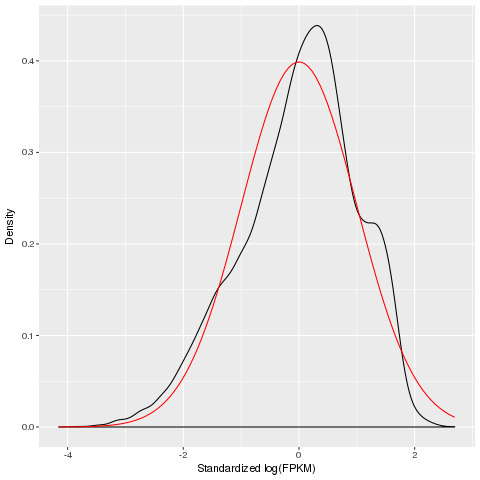

In [94]:
%%R
L <- log(exprs(ICELL8))
# Standardize each gene, so that they are all on the same scale,
# Then melt the data with plyr so we can plot it easily"
melted_dens_df <- melt(Matrix::t(scale(Matrix::t(L))))
# Plot the distribution of the standardized gene expression values.
qplot(value, geom="density", data=melted_dens_df) +  stat_function(fun = dnorm, size=0.5, color='red') +xlab("Standardized log(FPKM)") +ylab("Density")

In [95]:
%%R
table(pData(ICELL8)$celltype)


    ESC2 Pos_Ctrl     d2_2     d2_3     X3T3 
     116       10      125      125       10 


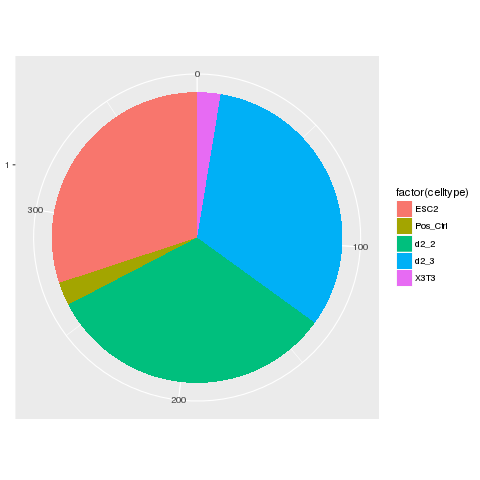

In [96]:
%%R
pie <- ggplot(pData(ICELL8), aes(x = factor(1), fill = factor(celltype))) +
geom_bar(width = 1)
pie + coord_polar(theta = "y") +
theme(axis.title.x=element_blank(), axis.title.y=element_blank())

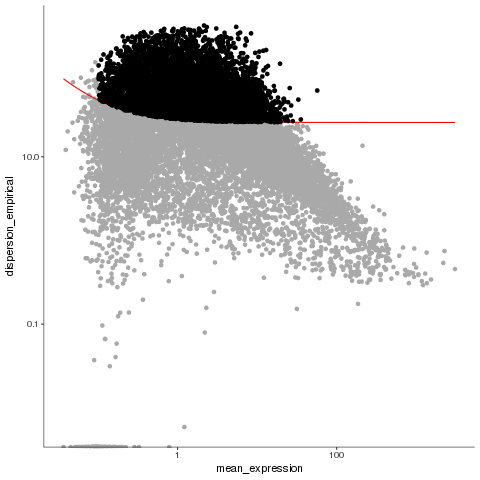

In [97]:
%%R
disp_table <- dispersionTable(ICELL8)
unsup_clustering_genes <- subset(disp_table, mean_expression >= 0.1 & dispersion_empirical >= 1 * dispersion_fit)
ICELL8 <- setOrderingFilter(ICELL8, unsup_clustering_genes$gene_id)
plot_ordering_genes(ICELL8)

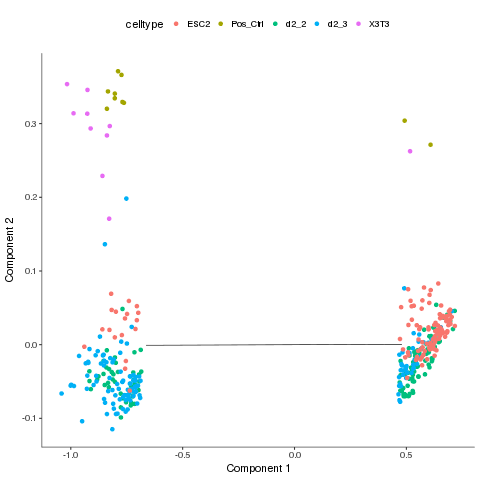

In [101]:
%%R
ICELL8 <- clusterCells(ICELL8, num_clusters=2)
plot_cell_trajectory(ICELL8, 1, 2, color="celltype")

In [108]:
%%R
ICELL8_d2_2 <- ICELL8[,pData(ICELL8)$celltype == "d2_2"]
#ICELL8_d2_2 <- estimateDispersions(ICELL8_d2_2)

In [109]:
%%R
diff_test_res <- differentialGeneTest(ICELL8_d2_2[expressed_genes,],
fullModelFormulaStr="~celltype")
ordering_genes <- row.names (subset(diff_test_res, qval < 0.01))

In [116]:
%%R
disp_table <- dispersionTable(ICELL8)
ordering_genes <- subset(disp_table,
mean_expression >= 0.5 &
dispersion_empirical >= 2 * dispersion_fit)$gene_id

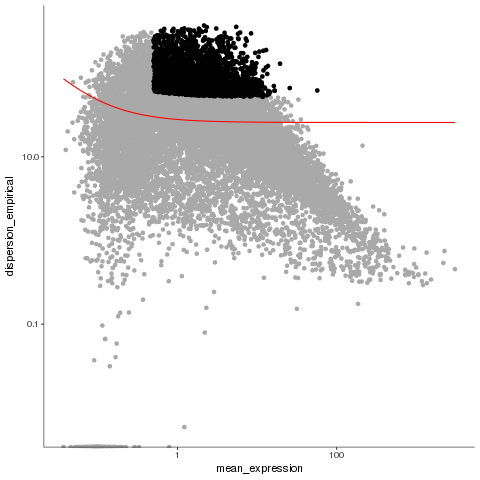

In [117]:
%%R
ICELL8 <- setOrderingFilter(ICELL8, ordering_genes)
plot_ordering_genes(ICELL8)

In [118]:
%%R
ICELL8 <- reduceDimension(ICELL8, max_components=2)

In [119]:
%%R
ICELL8 <- orderCells(ICELL8, reverse=FALSE)

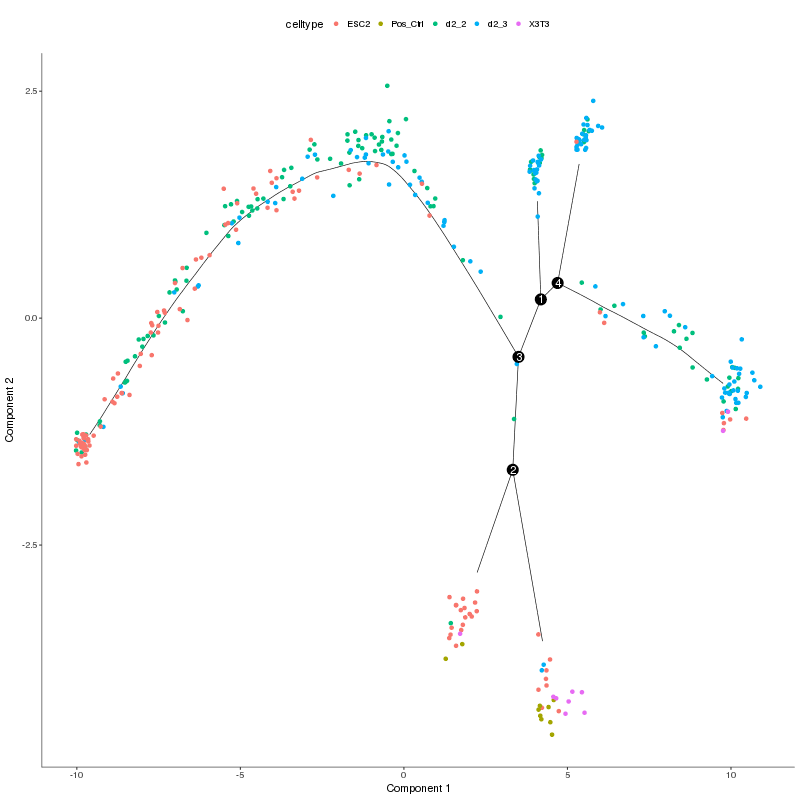

In [122]:
%%R -w 800 -h 800
plot_cell_trajectory(ICELL8, color_by="celltype")

In [ ]:
%%R
ICELL8_expressed_genes <-  row.names(subset(fData(ICELL8), num_cells_expressed >= 20))
ICELL8_filtered <-ICELL8[ICELL8_expressed_genes,]
#my_genes <- row.names(subset(fData(ICELL8_filtered),
#gene_short_name %in% c("CDK1", "MEF2C", "MYH3")))
cds_subset <- ICELL8_filtered

In [ ]:
%%R -w 800 -h 800
plot_genes_in_pseudotime(cds_subset, color_by="celltype")

## Now remove the controls and try again

In [118]:
%%R
report <- read.csv(file="sce-1059_mm_refseq_merged.report.csv",skip=8)
#genematrix <- read.table(file="sce-1059_mm_refseq.genematrix_sansUMI.csv", sep=",")
if(as.character(report[dim(report)[1],1]) == 'UNION'){
  union <- report[dim(report)[1],]
  union <- droplevels(union)
  report <- report[1:((dim(report)[1]) -1),]
  report <- droplevels(report)
}

report_sub <- report[!(report$Type %in% c("Neg_Ctrl")),]
report_sub <- droplevels(report_sub)
print(levels(report_sub$Type))
report_sub <- report_sub[!(report_sub$Type %in% c("Pos_Ctrl")),]
report_sub <- droplevels(report_sub)
print(levels(report_sub$Type))
report_sub <- report_sub[!(report_sub$Type %in% c("3T3")),]
report_sub <- droplevels(report_sub)
print(levels(report_sub$Type))

[1] "3T3"      "d2_2"     "d2_3"     "ESC2"     "Pos_Ctrl"
[1] "3T3"  "d2_2" "d2_3" "ESC2"
[1] "d2_2" "d2_3" "ESC2"


In [89]:
%%R
cd <- read.csv('cdAllCountTransWithAllCells.csv',row.names=1)

In [121]:
%%R
cdSelect <- cd[,gsub(".*_","",colnames(cd)) %in% report_sub$Barcode]
cdAllCountsFiltered <- clean.counts(cdSelect, min.lib.size=1800, min.reads = 50, min.detected = 20)

In [122]:
%%R
# factor determining cell types
sg <- factor(gsub("(d2_2|d2_3|ESC2).*", "\\1", report_sub$Type), levels = c("d2_2","d2_3","ESC2"))
# the group factor should be named accordingly
names(sg) <- colnames(report_sub$Type)  
table(sg)

sg
d2_2 d2_3 ESC2 
 125  125  125 


In [123]:
%%R
celltype <- factor(gsub("(d2_2|d2_3|ESC2).*", "\\1", colnames(cdAllCountsFiltered)), levels=c('ESC2','d2_2', 'd2_3'), labels=c('ESC2','d2_2', 'd2_3'))

In [124]:
%%R
cellPhenoData <- data.frame(cells= colnames(cdAllCountsFiltered), celltype=celltype)
count_matrix <- cdAllCountsFiltered
geneNames <- rownames(cdAllCountsFiltered)

In [125]:
%%R
pd <- new("AnnotatedDataFrame", data = cellPhenoData)
rownames(pd) <- cellPhenoData$cells

In [126]:
%%R
fd <- new("AnnotatedDataFrame", data = as.data.frame(geneNames))
rownames(fd) <- fd$geneNames

In [127]:
%%R
ICELL8 <- newCellDataSet(as.matrix(count_matrix),
                              phenoData = pd,
                              featureData = fd,
                              expressionFamily=negbinomial())

In [128]:
%%R
ICELL8 <- estimateSizeFactors(ICELL8)
ICELL8 <- estimateDispersions(ICELL8)

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Removing 586 outliers

  warnings.warn(x, RRuntimeWarning)


In [129]:
%%R
ICELL8  <- detectGenes(ICELL8 , min_expr = 0.1)
print(head(fData(ICELL8)))
expressed_genes <- row.names(subset(fData(ICELL8), num_cells_expressed >= 20))

                  geneNames num_cells_expressed
0610007P14Rik 0610007P14Rik                 204
0610009B22Rik 0610009B22Rik                 172
0610009O20Rik 0610009O20Rik                 129
0610010F05Rik 0610010F05Rik                  96
0610010K14Rik 0610010K14Rik                 213
0610030E20Rik 0610030E20Rik                 195


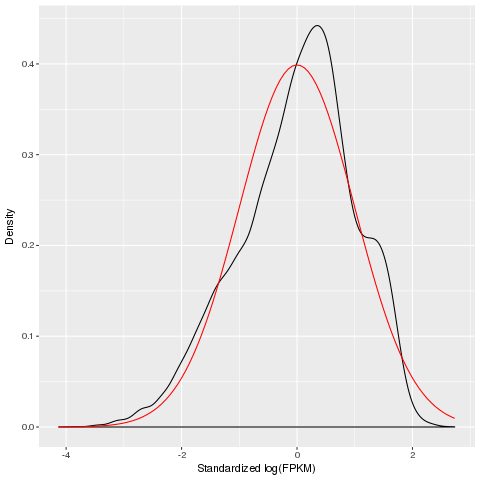

In [130]:
%%R
L <- log(exprs(ICELL8))
# Standardize each gene, so that they are all on the same scale,
# Then melt the data with plyr so we can plot it easily"
melted_dens_df <- melt(Matrix::t(scale(Matrix::t(L))))
# Plot the distribution of the standardized gene expression values.
qplot(value, geom="density", data=melted_dens_df) +  stat_function(fun = dnorm, size=0.5, color='red') +xlab("Standardized log(FPKM)") +ylab("Density")

In [131]:
%%R
table(pData(ICELL8)$celltype)


ESC2 d2_2 d2_3 
 116  125  125 


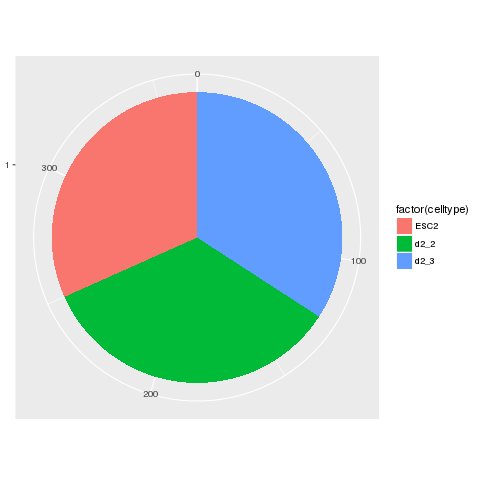

In [132]:
%%R
pie <- ggplot(pData(ICELL8), aes(x = factor(1), fill = factor(celltype))) +
geom_bar(width = 1)
pie + coord_polar(theta = "y") +
theme(axis.title.x=element_blank(), axis.title.y=element_blank())

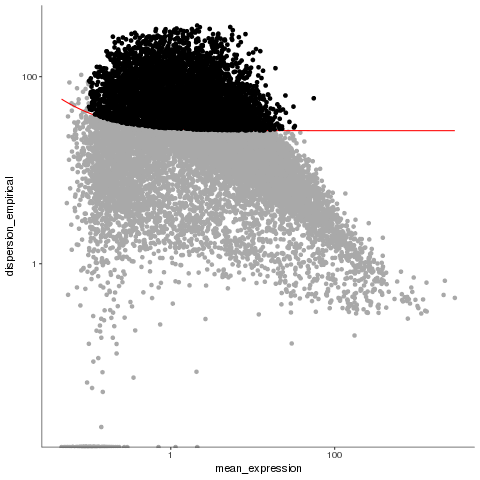

In [133]:
%%R
disp_table <- dispersionTable(ICELL8)
unsup_clustering_genes <- subset(disp_table, mean_expression >= 0.1 & dispersion_empirical >= 1 * dispersion_fit)
ICELL8 <- setOrderingFilter(ICELL8, unsup_clustering_genes$gene_id)
plot_ordering_genes(ICELL8)

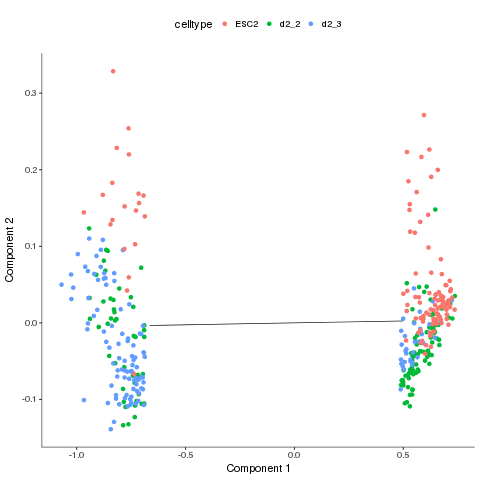

In [134]:
%%R
ICELL8 <- clusterCells(ICELL8, num_clusters=2)
plot_cell_trajectory(ICELL8, 1, 2, color="celltype")

In [135]:
%%R
disp_table <- dispersionTable(ICELL8)
ordering_genes <- subset(disp_table,
mean_expression >= 0.5 &
dispersion_empirical >= 2 * dispersion_fit)$gene_id

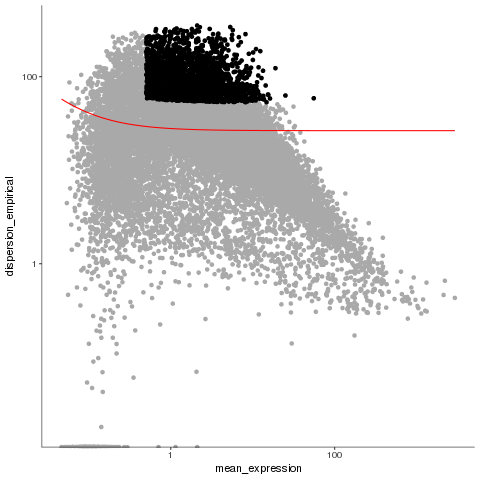

In [136]:
%%R
ICELL8 <- setOrderingFilter(ICELL8, ordering_genes)
plot_ordering_genes(ICELL8)

In [137]:
%%R
ICELL8 <- reduceDimension(ICELL8, max_components=2)

In [138]:
%%R
ICELL8 <- orderCells(ICELL8, reverse=FALSE)

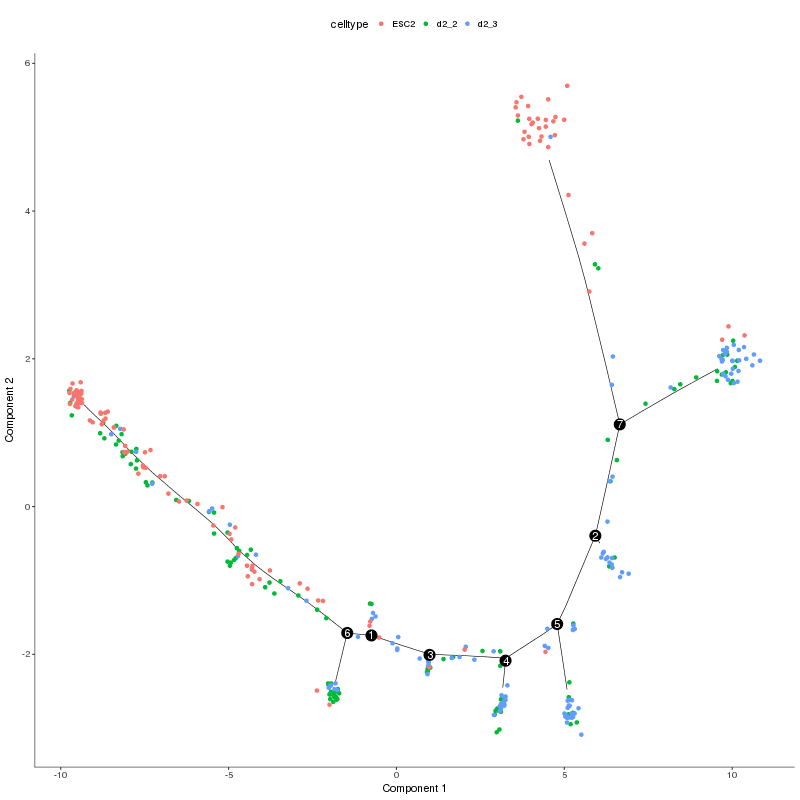

In [139]:
%%R -w 800 -h 800
plot_cell_trajectory(ICELL8, color_by="celltype")

In [164]:
%%R
ICELL8_expressed_genes <-  row.names(subset(fData(ICELL8), num_cells_expressed >= 20))
ICELL8_filtered <-ICELL8[ICELL8_expressed_genes,]
my_genes <- row.names(subset(fData(ICELL8_filtered),geneNames %in% c('Nanog','Klf4','Sox2','esrrb')))
cds_subset <- ICELL8_filtered[my_genes,]

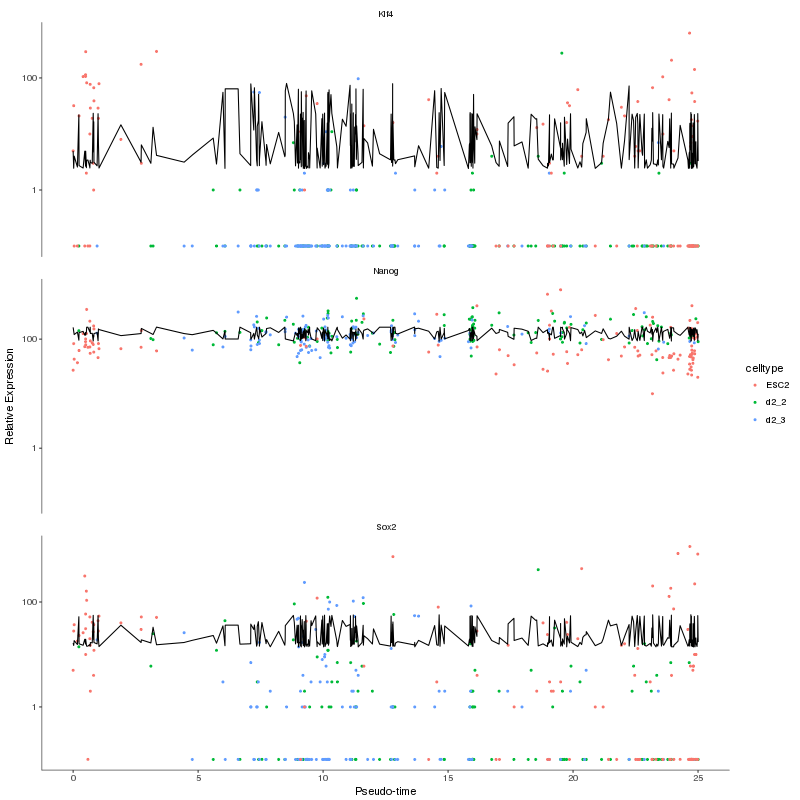

In [166]:
%%R -w 800 -h 800
plot_genes_in_pseudotime(cds_subset, color_by="celltype")